In [1]:
import pandas as pd
from spark_session import LocalSparkSession
from dataset import Dataset
from mr_id3 import MapReduceIDR3
from pyspark.mllib.tree import DecisionTree

In [2]:
from log import log
from sklearn.impute import SimpleImputer
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

In [3]:
%time
num_fields = [
    'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
    'hours_per_week', ]

categorical_fields = [
    'workclass', 'education',
    'marital_status', 'occupation', 'relationship',
    'race', 'sex', 'native_country', ]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [4]:
%time
target = 'label'
filename = 'dataset/adult.data'

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs


In [5]:
%time
numbers_of_cores = [4, ]
dataset_sizes = list(range(1, 31))
metrics = []

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [6]:
%time
for number_of_cores in numbers_of_cores:

    spark = LocalSparkSession(number_of_cores)
    spark.start()

    dataset = Dataset(spark.spark, filename, num_fields, categorical_fields, target)
    dataset.load()
    dataset.one_hot_encode_categorical_fields()

    for dataset_size in dataset_sizes:
        df = dataset.multiply_dataset(dataset_size)

        mr_id3 = MapReduceIDR3(df)
        mr_id3.set_labeled_point()
        mr_id3.split()
        mr_id3.train()

        metric = mr_id3.get_metrics()
        metric['length_rows'] = df.count()
        metric['dataset_size'] = dataset_size
        metric['number_of_cores'] = number_of_cores
        metrics.append(metric)
        log(f"Metrics: Clusters {metric['number_of_cores']} - File size {metric['dataset_size']}x - Time {metric['time']} seconds")

    spark.stop()

2022-10-15 19:07:04,686 [INFO] LocalSparkSession : Starting with 4 clusters


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/15 19:07:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


2022-10-15 19:07:08,989 [INFO] Dataset : Starting
2022-10-15 19:07:08,990 [INFO] Dataset : Loading Dataset dataset/adult.data
2022-10-15 19:07:12,596 [INFO] Dataset : One Hot Encode Categorical Fields
2022-10-15 19:07:20,906 [INFO] Dataset : Multiplying Dataset by 1x              
2022-10-15 19:07:21,071 [INFO] MapReduceIDR3 : Starting
2022-10-15 19:07:21,073 [INFO] MapReduceIDR3 : Setting Labeled Point
2022-10-15 19:07:21,669 [INFO] MapReduceIDR3 : Splitting
2022-10-15 19:07:21,670 [INFO] MapReduceIDR3 : Training
2022-10-15 19:07:26,351 [INFO] MapReduceIDR3 : Training time 4.679731 seconds   
2022-10-15 19:07:26,352 [INFO] MapReduceIDR3 : Get metrics
2022-10-15 19:07:26,893 [INFO] Metrics: Clusters 4 - File size 1x - Time 4.679731 seconds
2022-10-15 19:07:26,896 [INFO] Dataset : Multiplying Dataset by 2x
2022-10-15 19:07:27,114 [INFO] MapReduceIDR3 : Starting
2022-10-15 19:07:27,117 [INFO] MapReduceIDR3 : Setting Labeled Point
2022-10-15 19:07:27,458 [INFO] MapReduceIDR3 : Splitting
2

2022-10-15 19:08:31,185 [INFO] Dataset : Multiplying Dataset by 16x
2022-10-15 19:08:32,309 [INFO] MapReduceIDR3 : Starting
2022-10-15 19:08:32,310 [INFO] MapReduceIDR3 : Setting Labeled Point
2022-10-15 19:08:33,055 [INFO] MapReduceIDR3 : Splitting
2022-10-15 19:08:33,057 [INFO] MapReduceIDR3 : Training
2022-10-15 19:08:36,826 [INFO] MapReduceIDR3 : Training time 3.766223 seconds   
2022-10-15 19:08:36,829 [INFO] MapReduceIDR3 : Get metrics
2022-10-15 19:08:37,541 [INFO] Metrics: Clusters 4 - File size 16x - Time 3.766223 seconds
2022-10-15 19:08:37,545 [INFO] Dataset : Multiplying Dataset by 17x
2022-10-15 19:08:38,753 [INFO] MapReduceIDR3 : Starting
2022-10-15 19:08:38,754 [INFO] MapReduceIDR3 : Setting Labeled Point
2022-10-15 19:08:39,611 [INFO] MapReduceIDR3 : Splitting
2022-10-15 19:08:39,612 [INFO] MapReduceIDR3 : Training
2022-10-15 19:08:43,939 [INFO] MapReduceIDR3 : Training time 4.325318 seconds   
2022-10-15 19:08:43,941 [INFO] MapReduceIDR3 : Get metrics
2022-10-15 19:08:

In [7]:
%time
df = pd.DataFrame.from_dict(metrics)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [8]:
df

,time,length_rows,m_factor,n_cores
0,4.679731,800,1,4
1,2.719242,1200,2,4
2,2.296706,1600,3,4
3,2.485174,2000,4,4
4,2.282335,2400,5,4
5,2.744761,2800,6,4
6,2.442164,3200,7,4
7,2.788682,3600,8,4
8,3.235650,4000,9,4
9,2.966792,4400,10,4


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


<AxesSubplot: >

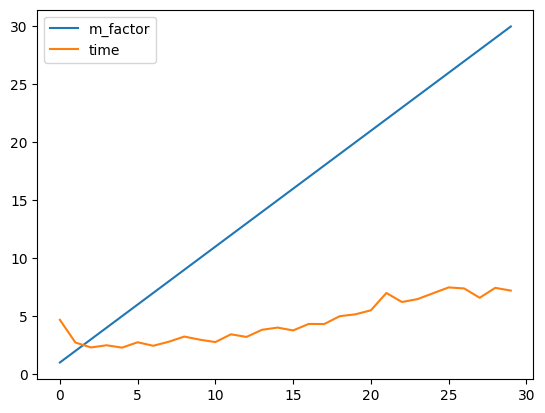

In [9]:
%time
df[['m_factor', 'time']].plot()